# L3: Attention

In this lab, you will implement the encoder–decoder architecture of [Sutskever et al., 2014](https://papers.nips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf), including the attention-based extension presented of [Bahdanau et al., 2015](https://arxiv.org/abs/1409.0473), and evaluate this architecture on a machine translation task.

In [ ]:
import torch

Training the models in this notebook requires significant compute power, and we strongly recommend using a GPU.

In [ ]:
device = torch.device('cuda')

## The data

We will build a system that translates from German (our **source language**) to English (our **target language**). The dataset is a collection of parallel English–German sentences taken from translations of subtitles for TED talks. It was derived from the [TED2013](https://opus.nlpl.eu/TED2013-v1.1.php) dataset, which is available in the [OPUS](http://opus.nlpl.eu/) collection. The code cell below prints the first lines in the training data:

In [ ]:
with open('train-de.txt') as src, open('train-en.txt') as tgt:
    for i, src_sentence, tgt_sentence in zip(range(5), src, tgt):
        print(f'{i}: {src_sentence.rstrip()} / {tgt_sentence.rstrip()}')

0: david gallo : das ist bill lange . ich bin dave gallo . / david gallo : this is bill lange . i 'm dave gallo .
1: wir werden ihnen einige geschichten über das meer in videoform erzählen . / and we 're going to tell you some stories from the sea here in video .
2: ich denke , das problem ist , dass wir das meer für zu selbstverständlich halten . / and the problem , i think , is that we take the ocean for granted .
3: wenn man darüber nachdenkt , machen die ozeane 75 % des planeten aus . / when you think about it , the oceans are 75 percent of the planet .
4: der großteil der erde ist meerwasser . / most of the planet is ocean water .


As you can see, some “sentences” are actually *sequences* of sentences, but we will use the term *sentence* nevertheless. All sentences are whitespace-tokenised and lowercased. To make your life a bit easier, we have removed sentences longer than 25 words.

The next cell contains code that yields the sentences contained in a file as lists of strings:

In [ ]:
def sentences(filename):
    with open(filename) as source:
        for line in source:
            yield line.rstrip().split()

## Problem 1: Build the vocabularies (2 points)

Your first task is to build the vocabularies for the data, one vocabulary for each language. Each vocabulary should contain the 10,000 most frequent words in the training data for the respective language.

In [ ]:
def make_vocab(sentences, max_size):
    vocab_dict = {'<pad>': 0, '<bos>': 1, '<eos>':2, '<unk>': 3}
    frequency_dict = {}
    for sentence in sentences:
        for word in sentence:
            if word in vocab_dict:
                frequency_dict[word] += 1
            else:
                frequency_dict[word] = 1
    # sort frequency dict by value
    frequency_dict = dict(sorted(frequency_dict.items(), key=lambda x: x[1], reverse=True))
    for word in frequency_dict:
        if len(vocab_dict) < max_size:
            vocab_dict[word] = len(vocab_dict)
        else:
            break

    return vocab_dict

Your implementation must comply with the following specification:

**make_vocab** (*sentences*, *max_size*)

> Returns a dictionary that maps the most frequent words in the *sentences* to a contiguous range of integers starting at&nbsp;0. The first four mappings in this dictionary are reserved for the pseudowords `<pad>` (padding, id&nbsp;0), `<bos>` (beginning of sequence, id&nbsp;1), `<eos>` (end of sequence, id&nbsp;2), and `<unk>` (unknown word, id&nbsp;3). The parameter *max_size* caps the size of the dictionary, including the pseudowords.

With this function, we can construct the vocabularies as follows:

In [ ]:
src_vocab = make_vocab(sentences('train-de.txt'), 10000)
print(len(src_vocab))
tgt_vocab = make_vocab(sentences('train-en.txt'), 10000)
print(len(tgt_vocab))

10000
10000


### 🤞 Test your code

To test you code, check that each vocabulary contains 10,000 words, including the pseudowords.

In [ ]:
print(src_vocab['<pad>'], src_vocab['<bos>'], src_vocab['<eos>'], src_vocab['<unk>'])
print(tgt_vocab['<pad>'], tgt_vocab['<bos>'], tgt_vocab['<eos>'], tgt_vocab['<unk>'])

0 1 2 3
0 1 2 3


## Load the data

The next cell defines a class for the parallel dataset. We sub-class the abstract [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, which represents map-style datasets in PyTorch. This will let us use standard infrastructure related to the loading and automatic batching of data.

In [ ]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):

    def __init__(self, src_vocab, src_filename, tgt_vocab, tgt_filename):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

        # We hard-wire the codes for <bos> (1), <eos> (2), and <unk> (3).
        self.src = [[self.src_vocab.get(w, 3) for w in s] for s in sentences(src_filename)]
        self.tgt = [[self.tgt_vocab.get(w, 3) for w in s] + [2] for s in sentences(tgt_filename)]

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

    def __len__(self):
        return len(self.src)

We load the training data:

In [ ]:
train_dataset = TranslationDataset(src_vocab, 'train-de.txt', tgt_vocab, 'train-en.txt')

The following function will be helpful for debugging. It extracts a single source–target pair of sentences from the specified *dataset* and converts it into batches of size&nbsp;1, which can be fed into the encoder–decoder model.

In [ ]:
def example(dataset, i):
    src, tgt = dataset[i]
    return torch.LongTensor(src).unsqueeze(0), torch.LongTensor(tgt).unsqueeze(0)

In [ ]:
example(train_dataset, 0)

(tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5, 11]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5, 11,  2]]))

## Problem 2: The encoder–decoder architecture

In this section, you will implement the encoder–decoder architecture, including the extension of that architecture by an attention mechanism. The implementation consists of four parts: the encoder, the attention mechanism, the decoder, and a class that wraps the complete architecture.

### Problem 2.1: Implement the encoder (2 points)

The encoder is relatively straightforward. We look up word embeddings and unroll a bidirectional GRU over the embedding vectors to compute a representation at each token position. We then take the last hidden state of the forward GRU and the last hidden state of the backward GRU, concatenate them, and pass them through a linear layer. This produces a summary of the source sentence, which we will later feed into the decoder.

To solve this problem, complete the skeleton code in the next code cell:

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):

    def __init__(self, num_words, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        # Bidirectional GRU layer
        self.rnn = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Final linear layer
        self.linear = nn.Linear(2 * hidden_dim, hidden_dim)

    def forward(self, src: torch.LongTensor):
        '''
        Input tensor has shape (batch_size, src_len)
        '''
        # Forward pass
        embedded = self.embedding(src)
        output, hidden = self.rnn(embedded)

        # Hidden shape: (2, src_len, hidden_dim)
        # print("Hidden tensor shape: ", hidden.shape)

        # Output shape: (batch_size, src_len, 2 * hidden_dim)
        # print("Output tensor shape: ", output.shape)

        # Output should have shape (batch_size, src_len, hidden_dim)
        output = self.linear(output)

        # Hidden should have shape (batch_size, hidden_dim)
        hidden = torch.tanh(self.linear(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return output, hidden

Your code must comply with the following specification:

**__init__** (*num_words*, *embedding_dim* = 256, *hidden_dim* = 512)

> Initialises the encoder. The encoder consists of an embedding layer that maps each of *num_words* words to an embedding vector of size *embedding_dim*, a bidirectional GRU that maps each embedding vector to a position-specific representation of size 2 × *hidden_dim*, and a final linear layer that projects these representationcons to new representations of size *hidden_dim*.

**forward** (*self*, *src*)

> Takes a tensor *src* with source-language word ids and sends it through the encoder. The input tensor has shape (*batch_size*, *src_len*), where *src_len* is the length of the sentences in the batch. (We will make sure that all sentences in the same batch have the same length.) The method returns a pair of tensors (*output*, *hidden*), where *output* has shape (*batch_size*, *src_len*, *hidden_dim*), and *hidden* has shape (*batch_size*, *hidden_dim*).

### 🤞 Test your code

To test your code, instantiate an encoder, feed it the first source sentence in the training data, and check that the tensors returned by the encoder have the expected shapes.

### Problem 2.2: Implement the attention mechanism (4 points)

In [ ]:
encoder = Encoder(len(src_vocab))
example_input = example(train_dataset, 3)[0]
example_input = torch.zeros(10, 14, dtype=torch.long)
print(example_input.shape)
output, hidden = encoder.forward(example_input)
print(output.shape, hidden.shape)

torch.Size([10, 14])
torch.Size([10, 14, 512]) torch.Size([10, 512])


Your next task is to implement the attention mechanism. Recall that the purpose of this mechanism is to inform the decoder when generating the translation of the next word. For this, attention has access to the previous hidden state of the decoder, as well as the complete output of the encoder. It returns the attention-weighted sum of the encoder output, the so-called *context* vector. For later usage, we also return the attention weights.

Attention can be implemented in various ways. One very simple implementation is *uniform attention*, which assigns equal weight to each position-specific representation in the output of the encoder, and completely ignores the hidden state of the decoder. This mechanism is implemented in the cell below.

In [ ]:
import torch.nn.functional as F

class UniformAttention(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, decoder_hidden, encoder_output, src_mask):
        batch_size, src_len, _ = encoder_output.shape

        # Set all attention scores to the same constant value (0). After
        # the softmax, we will have uniform weights.
        scores = torch.zeros(batch_size, src_len, device=encoder_output.device)

        print("Scores shape: ", scores.shape)
        print("Src mask shape: ", src_mask.shape)

        # Mask out the attention scores for the padding tokens. We set
        # them to -inf. After the softmax, we will have 0.
        scores.data.masked_fill_(~src_mask, -float('inf'))

        # Convert scores into weights
        alpha = F.softmax(scores, dim=1)

        # The context is the alpha-weighted sum of the encoder outputs.
        context = torch.bmm(alpha.unsqueeze(1), encoder_output).squeeze(1)

        return context, alpha

One technical detail in this code is our use of a mask *src_mask* to compute attention weights only for the “real” tokens in the source sentences, but not for the padding tokens that we introduce to bring all sentences in a batch to the same length.

Your task now is to implement the attention mechanism from the paper by [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473). The relevant equation is in Section&nbsp;A.1.2:

$$
a(s_{i-1}, h_j) = v^{\top} \tanh(W s_{i-1} + U h_j)
$$

This equation specifies how to compute the attention score (a scalar) for the previous hidden state of the decoder, denoted by&nbsp;$s_{i-1}$, and the $j$th position-specific representation in the output of the encoder, denoted by&nbsp;$h_j$. The equation refers to three parameters: a vector $v$ and $W$ and $U$. In PyTorch, these parameters can be represented in terms of (bias-free) linear layers that are trained along with the other parameters of the model.

Here is the skeleton code for this problem. As you can see, your specific task is to initialise the required parameters and to compute the attention scores (*scores*); the rest of the code is the same as for the uniform attention.

In [ ]:
class BahdanauAttention(nn.Module):

    def __init__(self, hidden_dim=512):
        super().__init__()
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U = nn.Linear(hidden_dim, hidden_dim, bias=False)


    def forward(self, decoder_hidden: torch.Tensor, encoder_output: torch.Tensor, src_mask: torch.Tensor):
        #batch_size, src_len, _ = encoder_output.shape

        scores = self.v(torch.tanh(self.W(decoder_hidden).unsqueeze(1) + self.U(encoder_output)))
        # Remove the extra dimension from scores
        scores = scores.squeeze(-1)

        #print("Scores shape: ", scores.shape)
        #print("Src mask shape: ", src_mask.shape)

        # The rest of the code is as in UniformAttention

        # Mask out the attention scores for the padding tokens. We set
        # them to -inf. After the softmax, we will have 0.
        scores.data.masked_fill_(~src_mask, -float('inf'))

        # Convert scores into weights
        alpha = F.softmax(scores, dim=1)

        # The context vector is the alpha-weighted sum of the encoder outputs.
        context = torch.bmm(alpha.unsqueeze(1), encoder_output).squeeze(1)

        return context, alpha

Your code must comply with the following specification:

**forward** (*decoder_hidden*, *encoder_output*, *src_mask*)

> Takes the previous hidden state of the decoder (*decoder_hidden*) and the encoder output (*encoder_output*) and returns a pair (*context*, *alpha*) where *context* is the context as computed as in [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473), and *alpha* are the corresponding attention weights. The hidden state has shape (*batch_size*, *hidden_dim*), the encoder output has shape (*batch_size*, *src_len*, *hidden_dim*), the context has shape (*batch_size*, *hidden_dim*), and the attention weights have shape (*batch_size*, *src_len*).

### 🤞 Test your code

To test your code, extend your test from Problem&nbsp;2.1: Feed the output of your encoder into your attention class. As the previous hidden state of the decoder, you can use the hidden state returned by the encoder. You will also need to create a source mask; this can be done as follows:

```
src_mask = (src != 0)
```

Check that the context tensor and the attention weights returned by the attention class have the expected shapes.

In [ ]:
# Test the attention mechanism
attention = BahdanauAttention()
src = example(train_dataset, 0)[0]
output, hidden = encoder(src)
src_mask = (src != 0)
context, alpha = attention(hidden, output, src_mask)
print(context.shape, alpha.shape)

torch.Size([1, 512]) torch.Size([1, 13])


### Problem 2.3: Implement the decoder (6 points)

Now you are ready to implement the decoder. Like the encoder, the decoder is based on a GRU; but this time we use a unidirectional network, as we generate the target sentences left-to-right.

**⚠️ We expect that solving this problem will take you the longest time in this lab.**

Because the decoder is an autoregressive model, we need to unroll the GRU “manually”: At each position, we take the previous hidden state as well as the new input, and apply the GRU for one step. The initial hidden state comes from the encoder. The new input is the embedding of the previous word, concatenated with the context vector from the attention model. To produce the final output, we take the output of the GRU, concatenate the embedding vector and the context vector (residual connection), and feed the result into a linear layer. Here is a graphical representation:

<img src="https://gitlab.liu.se/nlp/nlp-course/-/raw/master/labs/l3/decoder.svg" width="50%" alt="Decoder architecture"/>

We need to implement this manual unrolling for two very similar tasks: When *training*, both the inputs to and the target outputs of the GRU come from the training data. When *decoding*, the outputs of the GRU are used to generate new target-side words, and these words become the inputs to the next step of the unrolling. We have implemented methods `forward` and `decode` for these two different modes of usage. Your task is to implement a method `step` that takes a single step with the GRU.

In [ ]:
class Decoder(nn.Module):

    def __init__(self, num_words, attention, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.attention = attention
        self.rnn = nn.GRU(embedding_dim + hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(embedding_dim + 2 * hidden_dim, num_words)

    def forward(self, encoder_output, hidden, src_mask, tgt):
        batch_size, tgt_len = tgt.shape

        # Lookup the embeddings for the previous words
        embedded = self.embedding(tgt)

        # Initialise the list of outputs (in each sentence)
        outputs = []

        for i in range(tgt_len):
            # Get the embedding for the previous word (in each sentence)
            prev_embedded = embedded[:, i]

            # Take one step with the RNN
            output, hidden, alpha = self.step(encoder_output, hidden, src_mask, prev_embedded)

            # Update the list of outputs (in each sentence)
            outputs.append(output.unsqueeze(1))

        return torch.cat(outputs, dim=1)

    def decode(self, encoder_output, hidden, src_mask, max_len):
        batch_size = encoder_output.size(0)

        # Initialise the list of generated words and attention weights (in each sentence)
        generated = [torch.ones(batch_size, dtype=torch.long, device=hidden.device)]
        alphas = []

        for i in range(max_len):
            # Get the embedding for the previous word (in each sentence)
            prev_embedded = self.embedding(generated[-1])

            # Take one step with the RNN
            output, hidden, alpha = self.step(encoder_output, hidden, src_mask, prev_embedded)

            # Update the list of generated words and attention weights (in each sentence)
            generated.append(output.argmax(-1))
            alphas.append(alpha)

        generated = [x.unsqueeze(1) for x in generated[1:]]
        alphas = [x.unsqueeze(1) for x in alphas]

        return torch.cat(generated, dim=1), torch.cat(alphas, dim=1)

    def step(self, encoder_output, hidden, src_mask, prev_embedded):
        # Compute the context vector and attention weights
        context, alpha = self.attention(hidden, encoder_output, src_mask)

        rnn_input = torch.cat((prev_embedded, context), dim=1)

        # Take one step with the RNN
        rnn_output, hidden = self.rnn(rnn_input.unsqueeze(1), hidden.unsqueeze(0))

        linear_input = torch.cat((rnn_output.squeeze(1), rnn_input), dim=1)

        # Compute the output
        linear_output = self.linear(linear_input)

        return linear_output, hidden.squeeze(0), alpha

Your implementation should comply with the following specification:

**step** (*self*, *encoder_output*, *hidden*, *src_mask*, *prev_embedded*)

> Performs a single step in the manual unrolling of the decoder GRU. This takes the output of the encoder (*encoder_output*), the previous hidden state of the decoder (*hidden*), the source mask as described in Problem&nbsp;2.2 (*src_mask*), and the embedding vector of the previous word (*prev_embedded*), and computes the output as described above.
>
> The shape of *encoder_output* is (*batch_size*, *src_len*, *hidden_dim*); the shape of *hidden* is (*batch_size*, *hidden_dim*); the shape of *src_mask* is (*batch_size*, *src_len*); and the shape of *prev_embedded* is (*batch_size*, *embedding_dim*).
>
> The method returns a triple of tensors (*output*, *hidden*, *alpha*) where *output* is the position-specific output of the GRU, of shape (*batch_size*, *num_words*); *hidden* is the new hidden state, of shape (*batch_size*, *hidden_dim*); and *alpha* are the attention weights that were used to compute the *output*, of shape (*batch_size*, *src_len*).

#### 💡 Hints on the implementation

**Batch first!** Per default, the GRU implementation in PyTorch (just as the LSTM implementation) expects its input to be a three-dimensional tensor of the form (*seq_len*, *batch_size*, *input_size*). We find it conceptually easier to change this default behaviour and let the models take their input in the form (*batch_size*, *seq_len*, *input_size*). To do so, set *batch_first=True* when instantiating the GRU.

**Unsqueeze and squeeze.** When doing the unrolling manually, we get the input in the form (*batch_size*, *input_size*). To convert between this representation and the (*batch_size*, *seq_len*, *input_size*) representation, you can use [`unsqueeze`](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html) and [`squeeze`](https://pytorch.org/docs/stable/generated/torch.squeeze.html).

### 🤞 Test your code

To test your code, extend your test from the previous problems, and simulate a complete forward pass of the encoder–decoder architecture on the example sentence. Check the shapes of the resulting tensors.

In [ ]:
attention = BahdanauAttention()
encoder = Encoder(len(src_vocab))
decoder = Decoder(len(tgt_vocab), attention)
src = example(train_dataset, 0)[0]
output, hidden = encoder.forward(src)
src_mask = (src != 0)
tgt = example(train_dataset, 0)[1]
output = decoder(encoder_output=output, hidden=hidden, src_mask=src_mask, tgt=tgt)
print(output.shape)


torch.Size([1, 14, 10000])


### Encoder–decoder wrapper class

The last part of the implementation is a class that wraps the encoder and the decoder as a single model:

In [ ]:
class EncoderDecoder(nn.Module):

    def __init__(self, src_vocab_size, tgt_vocab_size, attention):
        super().__init__()
        self.encoder = Encoder(src_vocab_size)
        self.decoder = Decoder(tgt_vocab_size, attention)

    def forward(self, src, tgt):
        encoder_output, hidden = self.encoder(src)
        return self.decoder.forward(encoder_output, hidden, src != 0, tgt)

    def decode(self, src, max_len):
        encoder_output, hidden = self.encoder(src)
        return self.decoder.decode(encoder_output, hidden, src != 0, max_len)

### 🤞 Test your code

As a final test, instantiate an encoder–decoder model and use it to decode the example sentence. Check the shapes of the resulting tensors.

In [ ]:
encoder_decorder = EncoderDecoder(len(src_vocab), len(tgt_vocab), BahdanauAttention())
src = example(train_dataset, 0)[0]
output, alpha = encoder_decorder.decode(src, 512)
print(output.shape, alpha.shape)

torch.Size([1, 512]) torch.Size([1, 512, 13])


## Problem 3: Train a translator (2 points)

We now have all the pieces to build and train a complete translation system.

### Translator class

We first define a class `Translator` that initialises an encoder–decoder model and uses it to translate sentences. It can also return the attention weights that were used to produce the translation of each sentence.

In [ ]:
class Translator(object):

    def __init__(self, src_vocab, tgt_vocab, attention, device=torch.device('cuda')):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.device = device
        self.model = EncoderDecoder(len(src_vocab), len(tgt_vocab), attention).to('cuda')

    def translate_with_attention(self, sentences):
        # Encode each sentence
        encoded = [[self.src_vocab.get(w, 3) for w in s.split()] for s in sentences]

        # Determine the maximal length of an encoded sentence
        max_len = max(len(e) for e in encoded)

        # Build the input tensor, padding all sequences to the same length
        src = torch.LongTensor([e + [0] * (max_len - len(e)) for e in encoded]).to(self.device)

        # Run the decoder and convert the result into nested lists
        with torch.no_grad():
            decoded, alphas = tuple(d.cpu().numpy().tolist() for d in self.model.decode(src, 2 * max_len))

        # Prune each decoded sentence after the first <eos>
        i2w = {i: w for w, i in self.tgt_vocab.items()}
        result = []
        for d, a in zip(decoded, alphas):
            d = [i2w[i] for i in d]
            try:
                eos_index = d.index('<eos>')
                del d[eos_index:]
                del a[eos_index:]
            except:
                pass
            result.append((' '.join(d), a))

        return result

    def translate(self, sentences):
        translated, alphas = zip(*self.translate_with_attention(sentences))
        return translated

The code below shows how this class is supposed to be used:

In [ ]:
translator = Translator(src_vocab, tgt_vocab, BahdanauAttention())
translator.translate(['ich weiß nicht .', 'das haus ist klein .'])

('nagging volatility replacements certain lake comprised cubes hostility clouds survived',
 'nagging volatility replacements finale dirt grief carried marriage deliberately abolish')

### Evaluation function

Machine translation systems are typically evaluated using the BLEU metric. Here we use the implementation of this metric from the `sacrebleu` library.

In [ ]:
# If sacrebleu is not found, uncomment the next line:
!pip install sacrebleu

import sacrebleu

def bleu(translator, src, ref):
    translated = translator.translate(src)
    return sacrebleu.raw_corpus_bleu(translated, [ref], 0.01).score

We will report the BLEU score on the validation data:

In [ ]:
with open('valid-de.txt') as src, open('valid-en.txt') as ref:
    valid_src = [line.rstrip() for line in src]
    valid_ref = [line.rstrip() for line in ref]

### Batcher class

To prepare the training, we next create a class that takes a batch of encoded parallel sentences (a pair of lists of integers) and transforms it into two tensors, one for the source side and one for the target side. Each tensor contains sequences padded to the length of the longest sequence.

In [ ]:
class TranslationBatcher(object):

    def __init__(self, device):
        self.device = device

    def __call__(self, batch):
        srcs, tgts = zip(*batch)

        # Determine the maximal length of a source/target sequence
        max_src_len = max(len(s) for s in srcs)
        max_tgt_len = max(len(t) for t in tgts)

        # Create the source/target tensors
        S = torch.LongTensor([s + [0] * (max_src_len - len(s)) for s in srcs])
        T = torch.LongTensor([t + [0] * (max_tgt_len - len(t)) for t in tgts])

        return S.to(self.device), T.to(self.device)

### Training loop

The training loop resembles the training loops that you have seen in previous labs, except that we use a few new utilities from the PyTorch ecosystem.

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(n_epochs=2, batch_size=128, lr=5e-4):
    # Build the vocabularies
    vocab_src = make_vocab(sentences('train-de.txt'), 10000)
    vocab_tgt = make_vocab(sentences('train-en.txt'), 10000)

    # Prepare the dataset
    train_dataset = TranslationDataset(vocab_src, 'train-de.txt', vocab_tgt, 'train-en.txt')

    # Prepare the data loaders
    batcher = TranslationBatcher(device)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=batcher)

    # Build the translator
    translator = Translator(src_vocab, tgt_vocab, BahdanauAttention())

    # Initialise the optimiser
    optimizer = torch.optim.Adam(translator.model.parameters(), lr=lr)

    # Make it possible to interrupt the training
    try:
        for epoch in range(n_epochs):
            losses = []
            bleu_valid = 0
            sample = '<none>'
            with tqdm(total=len(train_dataset)) as pbar:
                for i, (src_batch, tgt_batch) in enumerate(train_loader):
                    # Create a shifted version of tgt_batch containing the previous words
                    batch_size, tgt_len = tgt_batch.shape
                    bos = torch.ones(batch_size, 1, dtype=torch.long, device=tgt_batch.device)
                    tgt_batch_shifted = torch.cat((bos, tgt_batch[:, :-1]), dim=1)

                    translator.model.train()

                    # Forward pass
                    scores = translator.model(src_batch, tgt_batch_shifted)
                    scores = scores.view(-1, len(tgt_vocab))

                    # Backward pass
                    optimizer.zero_grad()
                    loss = F.cross_entropy(scores, tgt_batch.view(-1), ignore_index=0)
                    loss.backward()
                    optimizer.step()

                    # Update the diagnostics
                    losses.append(loss.item())
                    pbar.set_postfix(loss=(sum(losses) / len(losses)), bleu_valid=bleu_valid, sample=sample)
                    pbar.update(len(src_batch))

                    if i % 50 == 0:
                        translator.model.eval()
                        bleu_valid = int(bleu(translator, valid_src, valid_ref))
                        sample = translator.translate(['das haus ist klein .'])[0]

    except KeyboardInterrupt:
        pass

    return translator

Now it is time to train the system. During training, two diagnostics will be printed periodically: the running average of the training loss, the BLEU score on the validation data, and the translation of a sample sentence, *das haus ist klein* (which should translate into *the house is small*).

As mentioned before, training the translator takes quite a bit of compute power and time. Even with a GPU, you should expect training times per epoch of about 8–10 minutes. The default number of epochs is&nbsp;2; however, you may want to interrupt the training prematurely and use a partially trained model in case you run out of time.

In [ ]:
translator = train()

100%|██████████| 143121/143121 [03:50<00:00, 619.94it/s, bleu_valid=19, loss=2.6, sample=it 's a house .]


**⚠️ Your submitted notebook must contain output demonstrating at least 16 BLEU points on the validation data.**

## Problem 4: Visualising attention (6 points)


Figure&nbsp;3 in the paper by [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473) shows some heatmaps of attention weights in selected sentences. In the last problem of this lab, we ask you to inspect attention weights for your trained translation system. We define a function `plot_attention` that visualises the attention weights. The *x* axis corresponds to the words in the source sentence (German) and the *y* axis to the generated target sentence (English). The heatmap colours represent the strengths of the attention weights.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn')

def plot_attention(translator, sentence):
    translation, weights = translator.translate_with_attention([sentence])[0]
    weights = np.array(weights)

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(weights, cmap='Blues_r')

    ax.set_xticklabels(sentence.split(), minor=False, rotation='vertical')
    ax.set_yticklabels(translation.split(), minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(weights.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(weights.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)

<ipython-input-192-c887944f02de>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Here is an example:

<ipython-input-192-c887944f02de>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sentence.split(), minor=False, rotation='vertical')
<ipython-input-192-c887944f02de>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(translation.split(), minor=False)


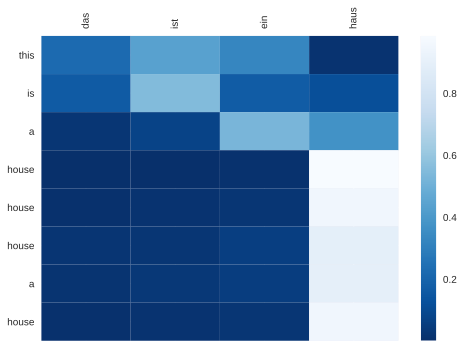

In [ ]:
plot_attention(translator, 'das ist ein haus')

Use these heatmaps to inspect the attention patterns for selected German sentences. Try to find sentences for which the model produces reasonably good English translations. If your German is a bit rusty (or non-existent), use sentences from the validation data. It might be interesting to look at examples where the German and the English word order differ substantially. Document your exploration in a short reflection piece (ca. 150 words). Respond to the following prompts:

* What sentences did you try out? What patterns did you spot? Include example heatmaps in your notebook.
* Based on what you know about attention, did you expect your results? Was there anything surprising in them?
* What did you learn? How, exactly, did you learn it? Why does this learning matter?

**🥳 Congratulations on finishing this lab! 🥳**

<ipython-input-192-c887944f02de>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sentence.split(), minor=False, rotation='vertical')
<ipython-input-192-c887944f02de>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(translation.split(), minor=False)


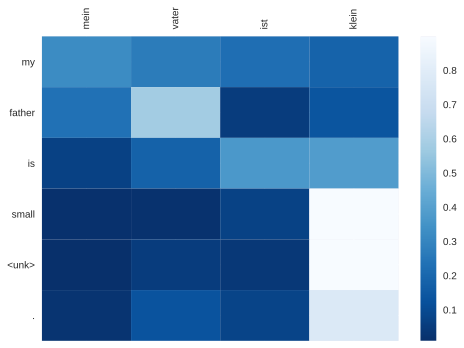

In [ ]:
plot_attention(translator, 'mein vater ist klein')

<ipython-input-192-c887944f02de>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sentence.split(), minor=False, rotation='vertical')
<ipython-input-192-c887944f02de>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(translation.split(), minor=False)


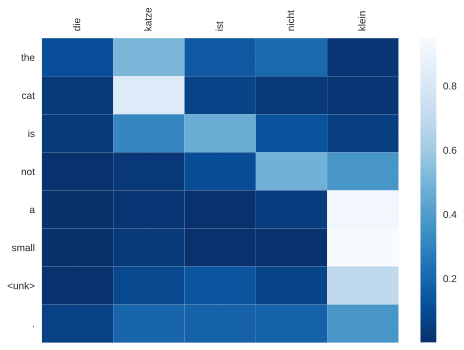

In [ ]:
plot_attention(translator, 'die katze ist nicht klein')

Report:

We tried the sentences "das ist ein haus", "mein vater ist klein" and "die katze ist nicht klein". These should have been translated to "That is a house", "My father is small" and "The cat is not small". The main pattern we look out for is the white diagonal line, from top left to the bottom right. However since the word order is not necessarily the same, it might differ a bit. For our sentences the model performed decently, with white spots corresponding more or less to the correct words, meaning the model pays attention to the correct things. Sometimes there is some abiguity with random words, for example the last sentece mapping "klein" fairly confidently to both "small" and "a".

Based on what we know about attention the results were more or less expected, the model mostly maps correct words to each other. Especially for the main nouns and adjectives, klein -> small, haus -> house etc. For the common grammar words it's usually a bit less confident. This might be because they occur a lot in different places so it might be hard to create a consistent mapping.

We learned how to build a model that's more sophisticated than the legacy ones, since we use the concept of attention which takes more context into account when assigning probability to the word mappings. We also learned how to resize tensors, and that Colab is sometimes a bit tricky to work with.

